In [1]:
import sys
import cv2
import numpy as np 
import pickle
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import batch_normalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.utils.image_utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
BS = 100
EPOCHS = 5
default_image_size = tuple((128, 128))
learning_rate = 0.001
image_size = 0
directory_root = 'Input/plantvillage dataset/color'
width=128
height=128
depth=3

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_disease_folder in root_dir:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{directory_root}/{plant_disease_folder}/")
                
        for single_plant_disease_image in plant_disease_image_list :
            if single_plant_disease_image == ".DS_Store" :
                plant_disease_image_list.remove(single_plant_disease_image)

        for image in plant_disease_image_list[:500]:
            image_directory = f"{directory_root}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Blueberry___healthy ...
[INFO] Processing Cherry_(including_sour)___healthy ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Peach___Bacterial_spot ...
[INFO] Processing Peach___healthy ...
[INFO] Processing Pepper,_bell___Bacterial_spot ...
[INFO] Processing Pepper,_bel

In [5]:
image_size = len(image_list)
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tom

In [9]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2)

[INFO] Spliting data to train, test


In [10]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [11]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications import MobileNetV2
from keras.utils.np_utils import to_categorical

# Get the MobileNetV2 model so we can do transfer learning
base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, 
                             input_shape=(128, 128, 3))
                             
# Add a global spatial average pooling layer
out = base_mobilenet.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_mobilenet.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_mobilenet.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(learning_rate=learning_rate, decay=learning_rate / EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=["accuracy"]) 

In [ ]:
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=45, 
    callbacks=[checkpoint],
    verbose=2
    )

c:\users\91700\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/45

Epoch 1: val_loss improved from inf to 0.52509, saving model to model.h5
143/143 - 141s - loss: 0.8855 - accuracy: 0.7374 - val_loss: 0.5251 - val_accuracy: 0.8375 - 141s/epoch - 987ms/step
Epoch 2/45

Epoch 2: val_loss improved from 0.52509 to 0.40077, saving model to model.h5
143/143 - 120s - loss: 0.4175 - accuracy: 0.8596 - val_loss: 0.4008 - val_accuracy: 0.8705 - 120s/epoch - 843ms/step
Epoch 3/45

Epoch 3: val_loss did not improve from 0.40077
143/143 - 124s - loss: 0.3394 - accuracy: 0.8865 - val_loss: 0.4553 - val_accuracy: 0.8587 - 124s/epoch - 870ms/step
Epoch 4/45

Epoch 4: val_loss improved from 0.40077 to 0.36810, saving model to model.h5
143/143 - 129s - loss: 0.2944 - accuracy: 0.9002 - val_loss: 0.3681 - val_accuracy: 0.8844 - 129s/epoch - 903ms/step
Epoch 5/45

Epoch 5: val_loss improved from 0.36810 to 0.34035, saving model to model.h5
143/143 - 129s - loss: 0.2648 - accuracy: 0.9079 - val_loss: 0.3403 - val_accuracy: 0.8911 - 129s/epoch - 901ms/step
Epoc

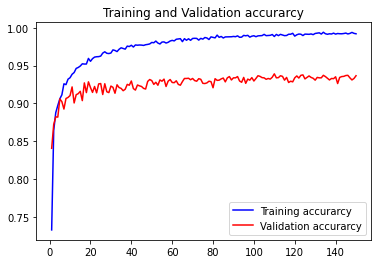

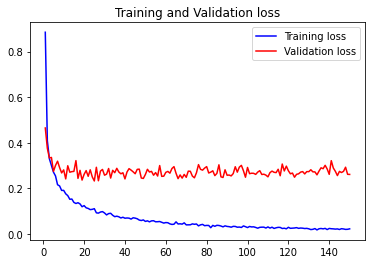

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [11]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
112/112 [==============================] - 27s 222ms/step - loss: 0.2609 - accuracy: 0.9366
Test Accuracy: 93.66275668144226


In [12]:
import joblib

from numpy.testing import assert_almost_equal

joblib.dump(model, 'mmmodel.pkl')

INFO:tensorflow:Assets written to: ram://4aba3ee7-80a3-4bc7-b241-6d4b2f55e2c2/assets


INFO:tensorflow:Assets written to: ram://4aba3ee7-80a3-4bc7-b241-6d4b2f55e2c2/assets


['mmmodel.pkl']

In [13]:
path = './model_final.h5'
model.save(path )